# Inverse MPC

This notebook accompanies the paper [Learning Convex Optimization Models](https://web.stanford.edu/~boyd/papers/learning_copt_models.html).

In [2]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm



# lessons learned:
# 1. the problem should feasible, convex, for any given parameters
# 2. Make sure the there is no product of two parameters that to be inferred



# ----------------- 1. Define the MPC problem -----------------



from cvxpylayers.torch import CvxpyLayer
torch.set_default_dtype(torch.double)
torch.set_default_device('cuda:3')

# define the nominal dynamics
n = 4 # state dimension
m = 1 # control dimension
dt = 0.1 # time integrator
A_np = np.array([[1., dt],[0, 1.]]) # dynamics of the ego car
A = np.kron(np.eye(2), A_np) # dynamics of the two cars
B1 = np.array([0,dt,0,0]).reshape(-1,1) # control of the ego car
B2 = np.array([0,0,0,dt]).reshape(-1,1) # control of the other car

A_torch = torch.tensor(A)
B1_torch = torch.tensor(B1)
B2_torch = torch.tensor(B2)


# define the ground truth parameters of the cost function
# parameters:   
#               weight_on_velocity_cost, 
#               weight_on_acceleration_cost, 
#               desired_distance, 
#               desired_velocity,
ground_truth_parameters = torch.tensor([1.0, 1.0, 0.5, 1.0])
ground_truth_parameters_np = ground_truth_parameters.cpu().numpy()
control_limit = 1.0 # this is the constraint on the control
T = 5 # look-ahead horizon


# define the dynamics and cost function
def dynamics_torch(xt, ut, acceleration_of_other_car = torch.tensor([0.])):
    return A_torch @ xt + B1_torch @ ut + B2_torch @ acceleration_of_other_car

def dynamics_np(xt, ut, acceleration_of_other_car = np.array([0.])):
    return A @ xt + B1 @ ut + B2 @ acceleration_of_other_car

def cost(xt, ut):
    return (ground_truth_parameters*(xt.pow(2))).sum() + ut.pow(2).sum()


# define MPC problem as below:
def construct_mpc_problem():
    # belows are the parameters of the MPC problem
    x = cp.Parameter(n)
    acceleration_of_other_car = cp.Parameter(1)
    # belows are the decision variables of the MPC problem
    states = [cp.Variable(n) for _ in range(T)]
    controls = [cp.Variable(m) for _ in range(T)]
    # initial constraints
    constraints = [states[0] == x, 
        cp.norm(controls[0], 'inf') <= control_limit,
        states[0][0] <= states[0][2] - ground_truth_parameters_np[2]] 
    # initial objective
    # 
    objective = cp.square(ground_truth_parameters_np[2]-(states[0][2]-states[0][0])) +\
        cp.multiply(ground_truth_parameters_np[0], cp.square(states[0][1] - ground_truth_parameters_np[3]))+\
        cp.multiply(ground_truth_parameters_np[1], cp.square(controls[0])) 
    for t in range(1, T):
        # objective
        #
        objective = cp.square(ground_truth_parameters_np[2]-(states[t][2]-states[t][0])) +\
            cp.multiply(ground_truth_parameters_np[0], cp.square(states[t][1] - ground_truth_parameters_np[3]))+\
            cp.multiply(ground_truth_parameters_np[1], cp.square(controls[t])) 
        # dynamics constraints
        constraints += [states[t] == A @ states[t-1] +\
            B1 @ controls[t-1] +\
            B2 @ acceleration_of_other_car] 
        # control constraints
        constraints += [cp.norm(controls[t], 'inf') <= control_limit]
        constraints += [states[t][0] <= states[t][2]- ground_truth_parameters_np[2]] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x, acceleration_of_other_car])


# simulate the closed-loop system
def simulate(policy, x0, acceleration_of_other_car, n_iters=1):
    states, controls, costs = [x0], [], []
    for t in tqdm(range(n_iters)):
        xt = states[-1] # current state
        # import pdb; pdb.set_trace()
        ut = policy(xt, acceleration_of_other_car)[0] # current control
        # record control, cost, and next state:
        controls.append(ut)
        states.append(dynamics_torch(xt, ut, acceleration_of_other_car))
    return states[:-1], controls


# define the mean square error
def mse(prediction, actual):
    prediction = torch.stack(prediction, dim=0)
    actual = torch.stack(actual, dim=0)
    return (prediction - actual).pow(2).mean(axis=1).mean(axis=0).item()






In [1]:
# Chris
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm



# lessons learned:
# 1. the problem should feasible, convex, for any given parameters
# 2. Make sure the there is no product of two parameters that to be inferred



# ----------------- 1. Define the MPC problem -----------------



from cvxpylayers.torch import CvxpyLayer
torch.set_default_dtype(torch.double)
torch.set_default_device('cuda:3')

# define the nominal dynamics
n = 4 # state dimension
m = 1 # control dimension
dt = 0.1 # time integrator
A_np = np.array([[1., dt],[0, 1.]]) # dynamics of the ego car
A = np.kron(np.eye(2), A_np) # dynamics of the two cars
B1 = np.array([0,dt,0,0]).reshape(-1,1) # control of the ego car
B2 = np.array([0,0,0,dt]).reshape(-1,1) # control of the other car

A_torch = torch.tensor(A)
B1_torch = torch.tensor(B1)
B2_torch = torch.tensor(B2)


# define the ground truth parameters of the cost function
# parameters:   
#               weight_on_velocity_cost, 
#               weight_on_acceleration_cost, 
#               desired_distance, 
#               desired_velocity,
# ground_truth_parameters = torch.tensor([1.0, 1.0, 0.5, 1.0])
# ground_truth_parameters_np = ground_truth_parameters.cpu().numpy()
control_limit = 10.0 # this is the constraint on the control
T = 5 # look-ahead horizon


# define the dynamics and cost function
def dynamics_torch(xt, ut, acceleration_of_other_car = torch.tensor([0.])):
    return A_torch @ xt + B1_torch @ ut + B2_torch @ acceleration_of_other_car

def dynamics_np(xt, ut, acceleration_of_other_car = np.array([0.])):
    return A @ xt + B1 @ ut + B2 @ acceleration_of_other_car

def cost(xt, ut):
    return (ground_truth_parameters*(xt.pow(2))).sum() + ut.pow(2).sum()


def construct_differentiable_mpc_problem(desired_speed):
    # belows are the parameters of the MPC problem
    x = cp.Parameter(n)
    inferred_parameters = cp.Parameter(3, nonneg=True) # this is the parameters of the problem
    acceleration_of_other_car = cp.Parameter(1)
    # belows are the decision variables of the MPC problem
    states = [cp.Variable(n) for _ in range(T)]
    controls = [cp.Variable(m) for _ in range(T)]
    # initial constraints
    constraints = [states[0] == x, 
        cp.norm(controls[0], 'inf') <= control_limit,
        states[0][0] <= states[0][2] - inferred_parameters[2]] 
    # initial objective
    # 
    objective = cp.square(inferred_parameters[2]-(states[0][2]-states[0][0])) +\
        cp.multiply(inferred_parameters[0], cp.square(states[0][1] - desired_speed))+\
        cp.multiply(inferred_parameters[1], cp.square(controls[0])) 
    for t in range(1, T):
        # objective
        #
        objective = cp.square(inferred_parameters[2]-(states[t][2]-states[t][0])) +\
            cp.multiply(inferred_parameters[0], cp.square(states[t][1] - desired_speed))+\
            cp.multiply(inferred_parameters[1], cp.square(controls[t])) 
        # dynamics constraints
        constraints += [states[t] == A @ states[t-1] +\
            B1 @ controls[t-1] +\
            B2 @ acceleration_of_other_car] 
        # control constraints
        constraints += [cp.norm(controls[t], 'inf') <= control_limit]
        constraints += [states[t][0] <= states[t][2]- inferred_parameters[2]] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x, acceleration_of_other_car, inferred_parameters])

x0 = torch.tensor([0., 100, 1000, 100])
acceleration_of_other_car = torch.tensor([0.])
theta_0 = 1.0 # 
theta_1 = 1.0
safe_distance = 500.
desired_speed = 1340.

mpc_problem = construct_differentiable_mpc_problem(desired_speed)
acceleration = mpc_problem(x0, acceleration_of_other_car, torch.tensor([theta_0, theta_1, safe_distance]))
acceleration

(tensor([-1.6425], device='cuda:3'),)

In [3]:


# ----------------- 2. Differentiable MPC -----------------



# define the differentiable MPC problem as below
# The problem bellow is the same as the MPC problem except that the parameters are inferred
def construct_differentiable_mpc_problem():
    # belows are the parameters of the MPC problem
    x = cp.Parameter(n)
    inferred_parameters = cp.Parameter(4, nonneg=True) # this is the parameters of the problem
    acceleration_of_other_car = cp.Parameter(1)
    # belows are the decision variables of the MPC problem
    states = [cp.Variable(n) for _ in range(T)]
    controls = [cp.Variable(m) for _ in range(T)]
    # initial constraints
    constraints = [states[0] == x, 
        cp.norm(controls[0], 'inf') <= control_limit,
        states[0][0] <= states[0][2] - inferred_parameters[2]] 
    # initial objective
    # 
    objective = cp.square(inferred_parameters[2]-(states[0][2]-states[0][0])) +\
        cp.multiply(inferred_parameters[0], cp.square(states[0][1] - ground_truth_parameters_np[3]))+\
        cp.multiply(inferred_parameters[1], cp.square(controls[0])) 
    for t in range(1, T):
        # objective
        # safe distance, safe speed, and control cost
        objective = cp.square(inferred_parameters[2]-(states[t][2]-states[t][0])) +\
            cp.multiply(inferred_parameters[0], cp.square(states[t][1] - ground_truth_parameters_np[3]))+\
            cp.multiply(inferred_parameters[1], cp.square(controls[t])) 
        # dynamics constraints
        constraints += [states[t] == A @ states[t-1] +\
            B1 @ controls[t-1] +\
            B2 @ acceleration_of_other_car] 
        # control constraints
        constraints += [cp.norm(controls[t], 'inf') <= control_limit]
        constraints += [states[t][0] <= states[t][2]- inferred_parameters[2]] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x, acceleration_of_other_car, inferred_parameters])




# ----------------- 3. test MPC and differentiable MPC -----------------



# initial state of two cars
x0 = torch.tensor([1.0, 0.2, 5.0, 1.0])
acceleration_of_other_car = torch.tensor([0.])


# define an MPC problem:
# In this MPC problem, we want to solve for the control given the initial state x0 and 
# the acceleration of the other car
mpc_problem = construct_mpc_problem()


# for example, we can solve the MPC problem for the initial state x0 and the acceleration of the other car
# Notice that the output of the function construct_mpc_problem is the first control, i.e., controls[0]
mpc_problem(x0, acceleration_of_other_car)




# generate expert state and control trajectories!
expert_states, expert_controls= simulate(mpc_problem, 
                                        x0, 
                                        acceleration_of_other_car, 
                                        n_iters = 100)





# define an MPC problem containing some hidden parameters that we want to infer
inferred_mpc_problem = construct_differentiable_mpc_problem()


# define the inferred policy: a function from a state to a control, under the inferred parameters
inferred_policy = lambda x, acceleration_of_other_car: inferred_mpc_problem(x, 
                                                acceleration_of_other_car, 
                                                inferred_parameters_torch)


# define the expert policy: a function from a state to a control, under the ground truth parameters
expert_policy = lambda x, acceleration_of_other_car: mpc_problem(x, 
                                    acceleration_of_other_car)





# ----------------- 4. training -----------------


# define the inferred parameters:
inferred_parameters_torch = torch.tensor([2.0, 2.0, 0.5, 1.0], requires_grad=True)

# the training loop:
training_epochs = 40 
test_losses = [] 
training_losses = [] 
test_x0 = x0
# initialize the training 
with torch.no_grad():
    _, initial_control_prediction = simulate(inferred_policy, test_x0, acceleration_of_other_car, n_iters = 100)
    _, test_expert_control = simulate(expert_policy, test_x0, acceleration_of_other_car, n_iters = 100)
    test_losses.append(mse(initial_control_prediction, test_expert_control))
    print(test_losses[-1])


# use Adam optimizer
opt = torch.optim.Adam([inferred_parameters_torch], lr=1e-4) 



100%|██████████| 100/100 [00:00<00:00, 451.08it/s]

0.04135958567858614


In [4]:
# training begins!
for epoch in range(training_epochs):
    print('Epoch: ', epoch)
    for xt, ut in tqdm(zip(expert_states, expert_controls)):
        opt.zero_grad()
        ut_hat = inferred_mpc_problem(xt, 
                                    acceleration_of_other_car, 
                                    inferred_parameters_torch)[0] # the output of the function is (controls[0])
        loss = (ut - ut_hat).pow(2).mean()
        loss.backward()
        training_losses.append(loss.item())
        opt.step()
    with torch.no_grad():
        inferred_parameters_torch.data = inferred_parameters_torch.relu()
        _, inferred_control_prediction = simulate(inferred_policy, 
                                                    test_x0, 
                                                    acceleration_of_other_car, 
                                                    n_iters = 100)
        test_losses.append(mse(inferred_control_prediction, test_expert_control))
    print(test_losses[-1])


print('Training finished!')

print('The inferred parameters are: ', inferred_parameters_torch.data)
print('The ground truth parameters are: ', ground_truth_parameters.data)




Epoch:  0


100it [00:00, 197.56it/s]
100%|██████████| 100/100 [00:00<00:00, 446.19it/s]


0.04053502314320543
Epoch:  1


100it [00:00, 197.69it/s]
100%|██████████| 100/100 [00:00<00:00, 452.12it/s]


0.04090062372316395
Epoch:  2


100it [00:00, 198.74it/s]
100%|██████████| 100/100 [00:00<00:00, 451.17it/s]


0.041202786866635005
Epoch:  3


100it [00:00, 174.29it/s]
100%|██████████| 100/100 [00:00<00:00, 452.16it/s]


0.04087416743325937
Epoch:  4


100it [00:00, 198.63it/s]
100%|██████████| 100/100 [00:00<00:00, 453.32it/s]


0.04033748536230317
Epoch:  5


100it [00:00, 199.41it/s]
100%|██████████| 100/100 [00:00<00:00, 451.68it/s]


0.0399844320967649
Epoch:  6


100it [00:00, 199.95it/s]
100%|██████████| 100/100 [00:00<00:00, 456.10it/s]


0.03903578177609265
Epoch:  7


100it [00:00, 200.32it/s]
100%|██████████| 100/100 [00:00<00:00, 452.55it/s]


0.042333667969227634
Epoch:  8


100it [00:00, 198.23it/s]
100%|██████████| 100/100 [00:00<00:00, 453.43it/s]


0.038394972105005636
Epoch:  9


100it [00:00, 199.61it/s]
100%|██████████| 100/100 [00:00<00:00, 452.99it/s]


0.03820966197554869
Epoch:  10


100it [00:00, 199.34it/s]
100%|██████████| 100/100 [00:00<00:00, 454.99it/s]


0.04066527432341938
Epoch:  11


100it [00:00, 199.74it/s]
100%|██████████| 100/100 [00:00<00:00, 453.65it/s]


0.04011035107438043
Epoch:  12


100it [00:00, 198.38it/s]
100%|██████████| 100/100 [00:00<00:00, 452.51it/s]


0.03963419847626601
Epoch:  13


100it [00:00, 199.15it/s]
100%|██████████| 100/100 [00:00<00:00, 452.27it/s]


0.03921334461962891
Epoch:  14


100it [00:00, 198.25it/s]
100%|██████████| 100/100 [00:00<00:00, 451.31it/s]


0.038727377825605765
Epoch:  15


100it [00:00, 183.41it/s]
100%|██████████| 100/100 [00:00<00:00, 452.06it/s]


0.038008821405416796
Epoch:  16


100it [00:00, 192.75it/s]
100%|██████████| 100/100 [00:00<00:00, 451.88it/s]


0.03774379917545522
Epoch:  17


100it [00:00, 198.09it/s]
100%|██████████| 100/100 [00:00<00:00, 451.04it/s]


0.038489972172413116
Epoch:  18


100it [00:00, 199.16it/s]
100%|██████████| 100/100 [00:00<00:00, 451.22it/s]


0.037281158957678424
Epoch:  19


100it [00:00, 198.91it/s]
100%|██████████| 100/100 [00:00<00:00, 454.54it/s]


0.03765580953788782
Epoch:  20


100it [00:00, 198.56it/s]
100%|██████████| 100/100 [00:00<00:00, 451.55it/s]


0.037614105671898504
Epoch:  21


100it [00:00, 199.04it/s]
100%|██████████| 100/100 [00:00<00:00, 453.33it/s]


0.036913532680369954
Epoch:  22


100it [00:00, 198.46it/s]
100%|██████████| 100/100 [00:00<00:00, 454.00it/s]


0.036415335078093886
Epoch:  23


100it [00:00, 196.11it/s]
100%|██████████| 100/100 [00:00<00:00, 452.76it/s]


0.03624571227544584
Epoch:  24


100it [00:00, 184.27it/s]
100%|██████████| 100/100 [00:00<00:00, 451.53it/s]


0.03912720554549573
Epoch:  25


100it [00:00, 199.63it/s]
100%|██████████| 100/100 [00:00<00:00, 431.86it/s]


0.03492495400683866
Epoch:  26


100it [00:00, 180.55it/s]
100%|██████████| 100/100 [00:00<00:00, 421.40it/s]


0.03463135989154876
Epoch:  27


100it [00:00, 197.95it/s]
100%|██████████| 100/100 [00:00<00:00, 443.23it/s]


0.034420056585931
Epoch:  28


100it [00:00, 199.41it/s]
100%|██████████| 100/100 [00:00<00:00, 450.94it/s]


0.03717959265136792
Epoch:  29


100it [00:00, 186.84it/s]
100%|██████████| 100/100 [00:00<00:00, 452.40it/s]


0.03679182511584621
Epoch:  30


100it [00:00, 198.60it/s]
100%|██████████| 100/100 [00:00<00:00, 447.95it/s]


0.0364283862755417
Epoch:  31


100it [00:00, 199.03it/s]
100%|██████████| 100/100 [00:00<00:00, 450.33it/s]


0.035712374133243054
Epoch:  32


100it [00:00, 198.52it/s]
100%|██████████| 100/100 [00:00<00:00, 449.92it/s]


0.035061730783091306
Epoch:  33


100it [00:00, 198.65it/s]
100%|██████████| 100/100 [00:00<00:00, 449.78it/s]


0.03504374086893353
Epoch:  34


100it [00:00, 199.90it/s]
100%|██████████| 100/100 [00:00<00:00, 451.06it/s]


0.03564310547133719
Epoch:  35


100it [00:00, 198.32it/s]
100%|██████████| 100/100 [00:00<00:00, 448.98it/s]


0.035552908979001555
Epoch:  36


100it [00:00, 198.25it/s]
100%|██████████| 100/100 [00:00<00:00, 451.35it/s]


0.03399740545431328
Epoch:  37


100it [00:00, 198.31it/s]
100%|██████████| 100/100 [00:00<00:00, 448.07it/s]


0.03458313023493169
Epoch:  38


100it [00:00, 199.48it/s]
100%|██████████| 100/100 [00:00<00:00, 451.91it/s]


0.03385071764805891
Epoch:  39


100it [00:00, 199.09it/s]
100%|██████████| 100/100 [00:00<00:00, 450.66it/s]

0.033756419146725794
Training finished!
The inferred parameters are:  tensor([2.1948, 1.9633, 0.5094, 1.0000], device='cuda:3')
The ground truth parameters are:  tensor([4.0000, 1.0000, 0.5000, 1.0000], device='cuda:3')


100%|██████████| 100/100 [00:00<00:00, 446.63it/s]

0.04135958567858614


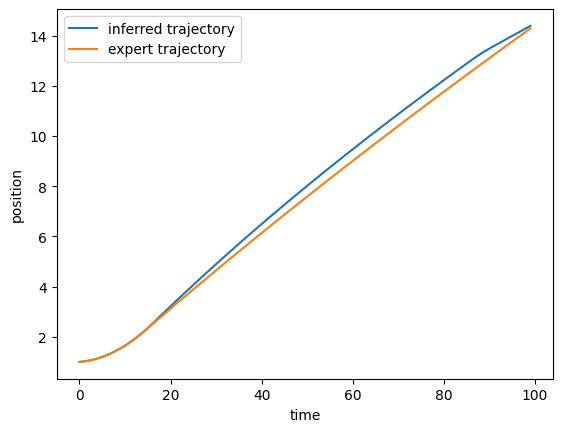

In [5]:

predicted_trajectory, predicted_control = [], []
expert_trajectory, expert_control = [], []
with torch.no_grad():
    predicted_trajectory, predicted_control = simulate(inferred_policy, test_x0, acceleration_of_other_car, n_iters = 100)
    expert_trajectory, expert_control = simulate(expert_policy, test_x0, acceleration_of_other_car, n_iters = 100)
    test_losses.append(mse(initial_control_prediction, test_expert_control))
    print(test_losses[-1])



import matplotlib
time_list = [x for x in range(100)]
import matplotlib.pyplot as plt
plt.plot(time_list, [x[0].cpu() for x in predicted_trajectory], label='inferred trajectory')
plt.plot(time_list, [x[0].cpu() for x in expert_trajectory], label='expert trajectory')
plt.xlabel("time")
plt.ylabel("position")
plt.legend()

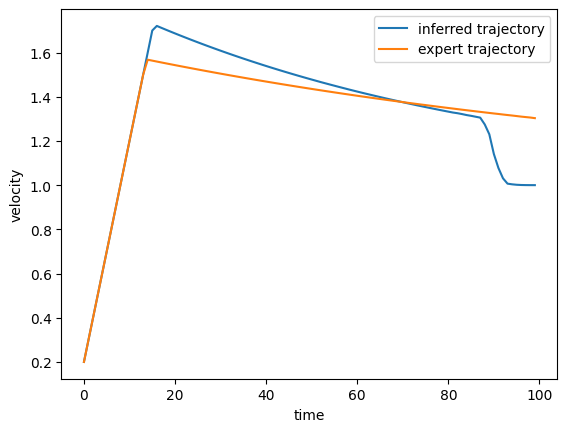

In [17]:
plt.plot(time_list, [x[1].cpu() for x in predicted_trajectory], label='inferred trajectory')
plt.plot(time_list, [x[1].cpu() for x in expert_trajectory], label='expert trajectory')
plt.xlabel("time")
plt.ylabel("velocity")
plt.legend()